In [1]:
%matplotlib inline
import os
import numpy as np
import time
import matplotlib as mpl
import matplotlib.pyplot as plt 
from mpl_toolkits import mplot3d
mpl.rcParams['lines.markersize'] = 3
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.init as init
from torch.optim.lr_scheduler import ExponentialLR

from utils.nn_models import *

torch.set_default_dtype(torch.float32)
torch.manual_seed(24)

MASS = 1.0
HBAR = 1.0
AUTOEV = 27.2114
AUTONM = 0.05291772108
NQGRID = 2048

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available.")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")

CUDA is available.


In [2]:
def plotBandStruct(bandStruct_array, marker_array, label_array): 
    fig, axs = plt.subplots(1,2, figsize=(7,3))
    for bandStructIndex in range(len(bandStruct_array)): 
        numBands = len(bandStruct_array[bandStructIndex][0])
        numKpts = len(bandStruct_array[bandStructIndex])
        for i in range(numBands): 
            if i==0: 
                axs[0].plot(np.arange(numKpts), bandStruct_array[bandStructIndex][:, i].detach().numpy(), marker_array[bandStructIndex], label=label_array[bandStructIndex])
                axs[1].plot(np.arange(numKpts), bandStruct_array[bandStructIndex][:, i].detach().numpy(), marker_array[bandStructIndex], label=label_array[bandStructIndex])
            else: 
                axs[0].plot(np.arange(numKpts), bandStruct_array[bandStructIndex][:, i].detach().numpy(), marker_array[bandStructIndex])
                axs[1].plot(np.arange(numKpts), bandStruct_array[bandStructIndex][:, i].detach().numpy(), marker_array[bandStructIndex])
    axs[0].legend(frameon=False)
    axs[1].set(ylim=(-8, -2))
    axs[0].get_xaxis().set_ticks([0, 20, 40, 45, 60])
    axs[0].get_xaxis().set_ticklabels(["L", r"$\Gamma$", "X", "K", r"$\Gamma$"])
    axs[1].get_xaxis().set_ticks([0, 20, 40, 45, 60])
    axs[1].get_xaxis().set_ticklabels(["L", r"$\Gamma$", "X", "K", r"$\Gamma$"])
    fig.tight_layout()
    plt.show()
    return fig

def pot_func(x, params): 
    pot = (params[0]*(x*x - params[1]) / (params[2] * torch.exp(params[3]*x*x) - 1.0))
    return pot

def realSpacePot(vq, qSpacePot): 
    # each input is a 1D tensor of torch.Size([nGrid]). vq is also assumed to be equally spaced. 
    dq = vq[1] - vq[0]
    nGrid = vq.shape[0]
    
    dr = 0.02*2*np.pi / (nGrid * dq)
    vr = torch.linspace(0, (nGrid - 1) * dr, nGrid)
    rSpacePot = torch.zeros(nGrid)
    
    for ir in range(nGrid): 
        if ir==0: 
            prefactor = 4*np.pi*dq / (8*np.pi**3)
            rSpacePot[ir] = torch.sum(prefactor * vq**2 * qSpacePot)
        else: 
            prefactor = 4*np.pi*dq / (8*np.pi**3 * vr[ir])
            rSpacePot[ir] = torch.sum(prefactor * vq * torch.sin(vq * vr[ir]) * qSpacePot)

    return (vr.view(-1,1), rSpacePot.view(-1,1))
    
def plotPP(q_array, vq_Cd_array, vq_Se_array, label_array, lineshape_array, boolPlotDiff): 
    if boolPlotDiff: 
        fig, axs = plt.subplots(1,3, figsize=(11,3))
        for i in range(len(q_array)): 
            q = q_array[i].view(-1).detach().numpy()
            vq_Cd = vq_Cd_array[i].view(-1).detach().numpy()
            vq_Se = vq_Se_array[i].view(-1).detach().numpy()
            axs[0].plot(q, vq_Cd, lineshape_array[i], label="Cd "+label_array[i])
            axs[0].plot(q, vq_Se, lineshape_array[i], label="Se "+label_array[i])
            (vr_Cd, rSpacePot_Cd) = realSpacePot(q_array[i].view(-1), vq_Cd_array[i].view(-1))
            (vr_Se, rSpacePot_Se) = realSpacePot(q_array[i].view(-1), vq_Se_array[i].view(-1))
            axs[2].plot(vr_Cd.view(-1).detach().numpy(), rSpacePot_Cd.view(-1).detach().numpy(), lineshape_array[i], label="Cd "+label_array[i])
            axs[2].plot(vr_Se.view(-1).detach().numpy(), rSpacePot_Se.view(-1).detach().numpy(), lineshape_array[i], label="Se "+label_array[i])
        axs[0].set(xlabel=r"$q$", ylabel=r"$v(q)$")
        axs[0].legend(frameon=False)
        
        axs[1].plot(q_array[0].view(-1).detach().numpy(), vq_Cd_array[1].view(-1).detach().numpy() - vq_Cd_array[0].view(-1).detach().numpy(), lineshape_array[0], label="Cd")
        axs[1].plot(q_array[0].view(-1).detach().numpy(), vq_Se_array[1].view(-1).detach().numpy() - vq_Se_array[0].view(-1).detach().numpy(), lineshape_array[0], label="Se")
        axs[1].set(xlabel=r"$q$", ylabel=r"$v_{NN}(q) - v_{func}(q)$")
        axs[1].legend(frameon=False)
        
        axs[2].set(xlabel=r"$r$", ylabel=r"$v(r)$", xlim=(0,12))
        axs[2].legend(frameon=False)
    else:
        fig, axs = plt.subplots(1,2, figsize=(7,3))
        for i in range(len(q_array)): 
            q = q_array[i].view(-1).detach().numpy()
            vq_Cd = vq_Cd_array[i].view(-1).detach().numpy()
            vq_Se = vq_Se_array[i].view(-1).detach().numpy()
            axs[0].plot(q, vq_Cd, lineshape_array[i], label="Cd "+label_array[i])
            axs[0].plot(q, vq_Se, lineshape_array[i], label="Se "+label_array[i])
            
            (vr_Cd, rSpacePot_Cd) = realSpacePot(q_array[i].view(-1), vq_Cd_array[i].view(-1))
            (vr_Se, rSpacePot_Se) = realSpacePot(q_array[i].view(-1), vq_Se_array[i].view(-1))
            axs[1].plot(vr_Cd.view(-1).detach().numpy(), rSpacePot_Cd.view(-1).detach().numpy(), lineshape_array[i], label="Cd "+label_array[i])
            axs[1].plot(vr_Se.view(-1).detach().numpy(), rSpacePot_Se.view(-1).detach().numpy(), lineshape_array[i], label="Se "+label_array[i])
        axs[0].set(xlabel=r"$q$", ylabel=r"$v(q)$")
        axs[0].legend(frameon=False)
        axs[1].set(xlabel=r"$r$", ylabel=r"$v(r)$", xlim=(0,12))
        axs[1].legend(frameon=False)
    fig.tight_layout()
    plt.show()
    return fig

def plot_training_validation_cost(training_cost, validation_cost, ylogBoolean): 
    if len(training_cost) != len(validation_cost): 
        return
    else:
        epochs = range(1, len(training_cost) + 1)
    
    # Plot training and validation costs
    fig, axs = plt.subplots(1,1, figsize=(8,6))
    
    axs.plot(epochs, training_cost, "b-", label='Training Cost')
    axs.plot(epochs, validation_cost, "r:", label='Validation Cost')
    
    if ylogBoolean:
        axs.set_yscale('log')
    else: 
        axs.set_yscale('linear')
    axs.set(xlabel="Epochs", ylabel="Cost", title="Training and Validation Costs")
    axs.legend(frameon=False)
    axs.grid(True)
    fig.tight_layout()
    plt.show()
    return fig

In [3]:
# Semiconductor system details
nSystem = 1

# read input
maxKE = 10
nBands = 16

# read multiple input

# read system
scale = 11.4485278
unitCellVector1 = torch.tensor([0.0, 0.5, 0.5]) * scale
unitCellVector2 = torch.tensor([0.5, 0.0, 0.5]) * scale
unitCellVector3 = torch.tensor([0.5, 0.5, 0.0]) * scale
unitCellVectors = torch.cat((unitCellVector1.unsqueeze(0), unitCellVector2.unsqueeze(0), unitCellVector3.unsqueeze(0)), dim=0)
cellVolume = torch.dot(unitCellVector1, torch.cross(unitCellVector2, unitCellVector3))
nAtoms = 2
atomTypes = np.array(["Cd", "Se"])
atomPos = torch.tensor([[0.125, 0.125, 0.125],
                        [-0.125, -0.125, -0.125]])
atomPos = atomPos @ unitCellVectors

# calculate reciprocal space vectors
prefactor = 2 * np.pi / cellVolume
gVector1 = prefactor * torch.cross(unitCellVectors[1], unitCellVectors[2])
gVector2 = prefactor * torch.cross(unitCellVectors[2], unitCellVectors[0])
gVector3 = prefactor * torch.cross(unitCellVectors[0], unitCellVectors[1])
gVectors = torch.cat((gVector1.unsqueeze(0), gVector2.unsqueeze(0), gVector3.unsqueeze(0)), dim=0).to(torch.float32)

# read kPoints
kpt_zbCdSe = torch.tensor(np.loadtxt("inputs/kpoints_0.par"), dtype=torch.float32)
kpt_zbCdSe = kpt_zbCdSe @ gVectors
nkpt = kpt_zbCdSe.shape[0]

# read band strcture
Eref_zbCdSe = torch.tensor(np.loadtxt("inputs/expBandStruct_0.par")[:, 1:])

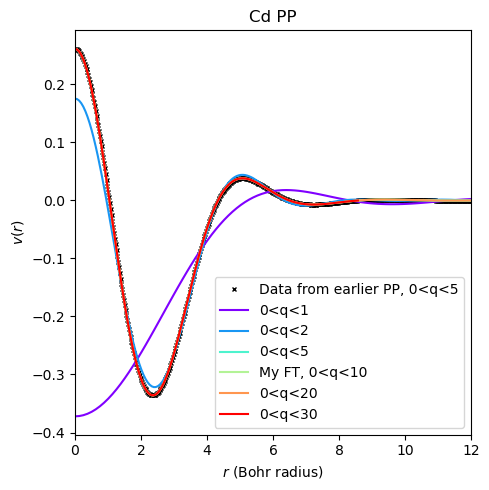

In [4]:
# Current Cd, Se, S pp's in Zunger's form
CdParams = torch.tensor([-31.4518, 1.3890, -0.0502, 1.6603, 0.0586])
SeParams = torch.tensor([8.4921, 4.3513, 1.3600, 0.3227, 0.1746])
SParams = torch.tensor([7.6697, 4.5192, 1.3456, 0.3035, 0.2087])
PP_order = np.array(["Cd", "Se", "S"])
totalParams = torch.cat((CdParams.unsqueeze(0), SeParams.unsqueeze(0), SParams.unsqueeze(0)), dim=0)

class init_Zunger_data(Dataset):
    def __init__(self,train=True):
        if train==True:
            self.q = (torch.rand(4000, 1) * 10.0).view(-1,1)
            self.q[0:10, 0] = 0.0
            self.vq_Cd = pot_func(self.q, CdParams)
            self.vq_Se = pot_func(self.q, SeParams)
            mask = (self.q > 0) & (self.q < 1)
            self.w = torch.where(mask, torch.tensor(10.0), torch.tensor(1.0))
        elif train==False:
            self.q = torch.linspace(0.0, 10.0, NQGRID).view(-1,1)
            self.vq_Cd = pot_func(self.q, CdParams)
            self.vq_Se = pot_func(self.q, SeParams)
            self.w = torch.ones_like(self.q)
        self.len = self.q.shape[0]
    def __getitem__(self,index):
        return self.q[index],self.vq_Cd[index],self.vq_Se[index],self.w[index]
    def __len__(self):
        return self.len
    
train_dataset = init_Zunger_data(True)
val_dataset = init_Zunger_data(False)


############## FT ##############

fig, axs = plt.subplots(1,1, figsize=(5,5))
Cd_rSpacePot_data = np.loadtxt("all_Sept13/potCd.par")
axs.plot(Cd_rSpacePot_data[:,0], Cd_rSpacePot_data[:,1], "kx", label="Data from earlier PP, 0<q<5")

cmap = plt.get_cmap('rainbow')
qmax = np.array([1.0, 2.0, 5.0, 10.0, 20.0, 30.0])

for i, color in enumerate(cmap(np.linspace(0, 1, len(qmax)))):
    q = torch.linspace(0.0, qmax[i], NQGRID)
    (val_vr_Cd, val_rSpacePot_Cd) = realSpacePot(q, pot_func(q, CdParams))
    (val_vr_Se, val_rSpacePot_Se) = realSpacePot(q, pot_func(q, SeParams))
    if qmax[i]==10: 
        axs.plot(val_vr_Cd, val_rSpacePot_Cd, "-", color=color, label="My FT, 0<q<%d" % qmax[i])
    else:
        axs.plot(val_vr_Cd, val_rSpacePot_Cd, "-", color=color, label="0<q<%d" % qmax[i])

axs.set(xlim=(0,12), title="Cd PP", xlabel=r"$r$ (Bohr radius)", ylabel=r"$v(r)$")
axs.legend()
fig.tight_layout()
plt.show()

def FT_converge_and_write_pp(qmax_array, model, xmin, xmax, ymin, ymax, choiceQMax, choiceNQGrid, ppPlotFile, potCdFile, potSeFile):
    cmap = plt.get_cmap('rainbow')
    figtot, axstot = plt.subplots(1,2, figsize=(10,5))
    for i, color in enumerate(cmap(np.linspace(0, 1, len(qmax_array)))):
        plotqGrid = torch.linspace(0.0, qmax_array[i], NQGRID).view(-1, 1)
        NN = model(plotqGrid)
        (vr_Cd, rSpacePot_Cd) = realSpacePot(plotqGrid.view(-1), NN[:, 0].view(-1))
        (vr_Se, rSpacePot_Se) = realSpacePot(plotqGrid.view(-1), NN[:, 1].view(-1))
        if qmax_array[i]==30: 
            axstot[0].plot(vr_Cd.detach().numpy(), rSpacePot_Cd.detach().numpy(), "-", color=color, label="My FT, 0<q<%d" % qmax_array[i])
            axstot[1].plot(vr_Se.detach().numpy(), rSpacePot_Se.detach().numpy(), "-", color=color, label="My FT, 0<q<%d" % qmax_array[i])
        else:
            axstot[0].plot(vr_Cd.detach().numpy(), rSpacePot_Cd.detach().numpy(), "-", color=color, label="0<q<%d" % qmax_array[i])
            axstot[1].plot(vr_Se.detach().numpy(), rSpacePot_Se.detach().numpy(), "-", color=color, label="0<q<%d" % qmax_array[i])
    
    axstot[0].set(xlim=(xmin, xmax), ylim=(ymin, ymax), title="Cd PP", xlabel=r"$r$ (Bohr radius)", ylabel=r"$v(r)$")
    axstot[1].set(xlim=(xmin, xmax), ylim=(ymin, ymax), title="Se PP", xlabel=r"$r$ (Bohr radius)", ylabel=r"$v(r)$")
    axstot[0].legend()
    figtot.tight_layout()
    plt.show()
    
    choiceQGrid = torch.linspace(0.0, choiceQMax, choiceNQGrid).view(-1, 1)
    NN = model(choiceQGrid)
    fig = plotPP([val_dataset.q, choiceQGrid], [val_dataset.vq_Cd, NN[:, 0]], [val_dataset.vq_Se, NN[:, 1]], ["ZungerForm", f"NN_init_Zunger"], ["-", ":"], False);
    fig.savefig(ppPlotFile)
    (vr_Cd, rSpacePot_Cd) = realSpacePot(choiceQGrid.view(-1), NN[:, 0].view(-1))
    (vr_Se, rSpacePot_Se) = realSpacePot(choiceQGrid.view(-1), NN[:, 1].view(-1))
    potCd = torch.cat((vr_Cd, rSpacePot_Cd), dim=1).detach().numpy()
    potSe = torch.cat((vr_Se, rSpacePot_Se), dim=1).detach().numpy()
    np.savetxt(potCdFile, potCd, delimiter='    ', fmt='%e')
    np.savetxt(potSeFile, potCd, delimiter='    ', fmt='%e')
    return

We see that the Fourier transform is easily converged on the Zunger function form. However, this is an important aspect to check for the NN pseudopotentials, as their convergence isn't guaranteed. 

$$
\begin{align}
    v(r) &= \frac{4\pi}{(2\pi)^3} \int_0^\infty dq q^2 v(q) \frac{\sin(qr)}{qr} \\
         &= \frac{4\pi}{(2\pi)^3} \sum_{qGrid} \Delta q q^2 v(q) \frac{\sin(qr)}{qr}
\end{align}
$$

In order for the Fourier transform integral to converge, we must have 
$$
\frac{4\pi}{(2\pi)^3} \sum_{q=q_{conv}}^\infty \Delta q q^2 v(q) \frac{\sin(qr)}{qr} \rightarrow 0
$$
And thus, the reciprocal space pseudopotential $v(q)$ must decay faster than $q$ (or better, $q^2$). Thus, I choose an sigmoid function, which has exponential decay for large $q$. 
$$
v(q) = NN * \left(1-\frac{1}{1+e^{-1.5(q-6)}}\right)
$$
The choice of the decay rate (1.5) and decay center (6) aren't tuned so far. 

In [5]:
def basis(maxKE, scale, unitCellVectors, gVectors, cellVolume): 
    minGMag = min(torch.norm(gVectors[0]), torch.norm(gVectors[1]), torch.norm(gVectors[2]))
    numMaxBasisVectors = int(np.sqrt(2*maxKE) / minGMag)
    # print(numMaxBasisVectors)

    k = torch.arange(-numMaxBasisVectors, numMaxBasisVectors+1, dtype=torch.float32).repeat((2*numMaxBasisVectors+1)**2)
    j = torch.arange(-numMaxBasisVectors, numMaxBasisVectors+1, dtype=torch.float32).repeat_interleave((2*numMaxBasisVectors+1)).repeat((2*numMaxBasisVectors+1))
    i = torch.arange(-numMaxBasisVectors, numMaxBasisVectors+1, dtype=torch.float32).repeat_interleave((2*numMaxBasisVectors+1)**2)
    allGrid = torch.vstack((i, j, k)).T
    transform = gVectors.T
    allBasisSet = allGrid @ transform
    # print(allBasisSet.shape[0])
    # print(allBasisSet)

    row_norms = torch.norm(allBasisSet, dim=1)
    condition = (HBAR*0.5*row_norms**2 / MASS < maxKE)
    indices = torch.where(condition)[0]
    basisSet = allBasisSet[indices]
    # print(basisSet.shape[0])
    # print(basisSet)
    
    sorting_indices = torch.argsort(basisSet[:, 2], stable=True)
    basisSet = basisSet[sorting_indices]
    sorting_indices = torch.argsort(basisSet[:, 1], stable=True)
    basisSet = basisSet[sorting_indices]
    sorting_indices = torch.argsort(basisSet[:, 0], stable=True)
    basisSet = basisSet[sorting_indices]
    row_norms = torch.norm(basisSet, dim=1)
    sorting_indices = torch.argsort(row_norms[:], stable=True)
    sorted_basisSet = basisSet[sorting_indices]
    
    return sorted_basisSet

'''
# construct hamiltonian at a certain k-point (kVector). 
def calcHamiltonianMatrix(NN_boolean, model, basisStates, kVector, nAtoms, atomPos, cellVolume):
    n = basisStates.shape[0]
    HMatrix = torch.zeros((n, n), dtype=torch.complex128)

    # Kinetic energy
    for i in range(n): 
        HMatrix[i,i] += HBAR**2 / (2*MASS) * (torch.norm(basisStates[i] + kVector))**2
        
    # Local potential
    gDiff = torch.stack([basisStates] * (basisStates.shape[0]), dim=1) - basisStates.repeat(basisStates.shape[0], 1, 1)
    
    for k in range(nAtoms): 
        gDiffDotTau = torch.sum(gDiff * atomPos[k], axis=2)
        structFact = 1/cellVolume * (torch.cos(gDiffDotTau) + 1j*torch.sin(gDiffDotTau))

        thisAtomIndex = np.where(atomTypes[k]==PP_order)[0]
        if len(thisAtomIndex)!=1: 
            raise ValueError("Type of atoms in PP. ")
        thisAtomIndex = thisAtomIndex[0]
        
        if NN_boolean: 
            atomFF = model(torch.norm(gDiff, dim=2).view(-1, 1))
            atomFF = atomFF[:, thisAtomIndex].view(n, n)
        else: 
            atomFF = pot_func(torch.norm(gDiff, dim=2), totalParams[thisAtomIndex])
        
        HMatrix += atomFF * structFact
    return HMatrix

# calculate the band structure at all k-points
def calcBandStruct(NN_boolean, model, basisStates, nkpt, kpts_coord, nAtoms, atomPos, cellVolume, nBands): 
    bandStruct = torch.zeros((nkpt, nBands))
    for kpt_index in range(nkpt): 
        HamiltonianMatrixAtKpt = calcHamiltonianMatrix(NN_boolean, model, basisStates, kpts_coord[kpt_index], nAtoms, atomPos, cellVolume)

        # diagonalize the hamiltonian
        energies = torch.linalg.eigvalsh(HamiltonianMatrixAtKpt)
        
        energiesEV = energies * AUTOEV
        # 2-fold degeneracy due to spin
        final_energies = energiesEV.repeat_interleave(2)[:nBands]
    
        bandStruct[kpt_index] = final_energies

    return bandStruct
'''

################## GPU ##################

def calcHamiltonianMatrix_GPU(NN_boolean, model, basisStates, kVector, nAtoms, atomPos, cellVolume, device):
    model.to(device)
    basisStates = basisStates.to(device)
    kVector = kVector.to(device)
    atomPos = atomPos.to(device)
    n = basisStates.shape[0]
    HMatrix = torch.zeros((n, n), dtype=torch.complex128)
    HMatrix = HMatrix.to(device)

    # Kinetic energy
    for i in range(n): 
        HMatrix[i,i] += HBAR**2 / (2*MASS) * (torch.norm(basisStates[i] + kVector))**2
    
    # Local potential
    gDiff = torch.stack([basisStates] * (basisStates.shape[0]), dim=1) - basisStates.repeat(basisStates.shape[0], 1, 1)
    
    for k in range(nAtoms): 
        gDiffDotTau = torch.sum(gDiff * atomPos[k], axis=2)
        structFact = 1/cellVolume * (torch.cos(gDiffDotTau) + 1j*torch.sin(gDiffDotTau))

        thisAtomIndex = np.where(atomTypes[k]==PP_order)[0]
        if len(thisAtomIndex)!=1: 
            raise ValueError("Type of atoms in PP. ")
        thisAtomIndex = thisAtomIndex[0]
        
        if NN_boolean: 
            atomFF = model(torch.norm(gDiff, dim=2).view(-1, 1))
            atomFF = atomFF[:, thisAtomIndex].view(n, n)
        else: 
            atomFF = pot_func(torch.norm(gDiff, dim=2), totalParams[thisAtomIndex])
        
        HMatrix += atomFF * structFact
    return HMatrix

def calcBandStruct_GPU(NN_boolean, model, basisStates, nkpt, kpts_coord, nAtoms, atomPos, cellVolume, nBands, device): 
    bandStruct = torch.zeros((nkpt, nBands))
    for kpt_index in range(nkpt): 
        HamiltonianMatrixAtKpt = calcHamiltonianMatrix_GPU(NN_boolean, model, basisStates, kpts_coord[kpt_index], nAtoms, atomPos, cellVolume, device)
        # diagonalize the hamiltonian
        energies = torch.linalg.eigvalsh(HamiltonianMatrixAtKpt)
        
        energiesEV = energies * AUTOEV
        # 2-fold degeneracy due to spin
        final_energies = energiesEV.repeat_interleave(2)[:nBands]
    
        bandStruct[kpt_index] = final_energies

    return bandStruct

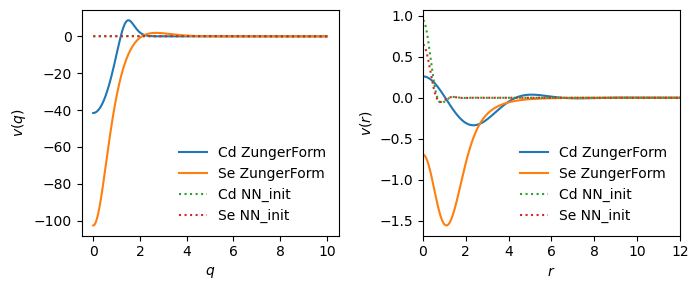

Epoch [500/1000], Validation Loss: 0.0491


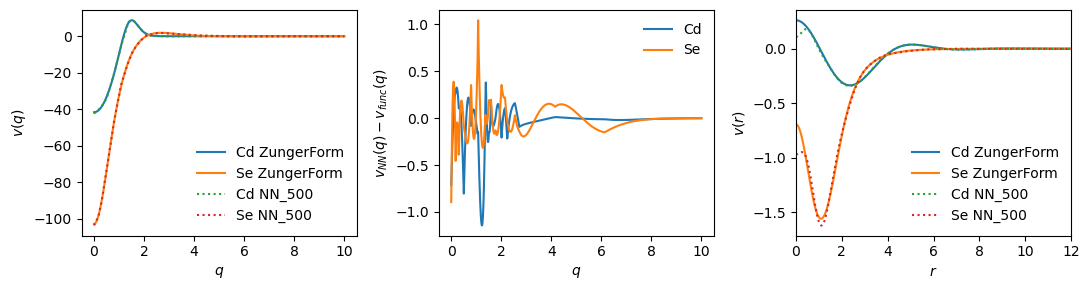

Epoch [1000/1000], Validation Loss: 0.0442


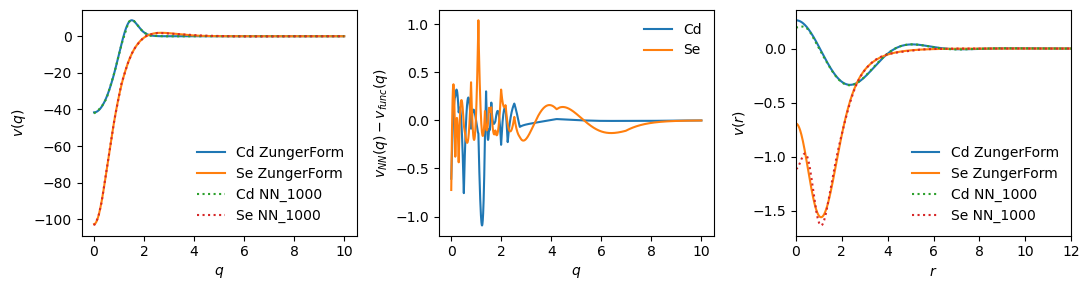

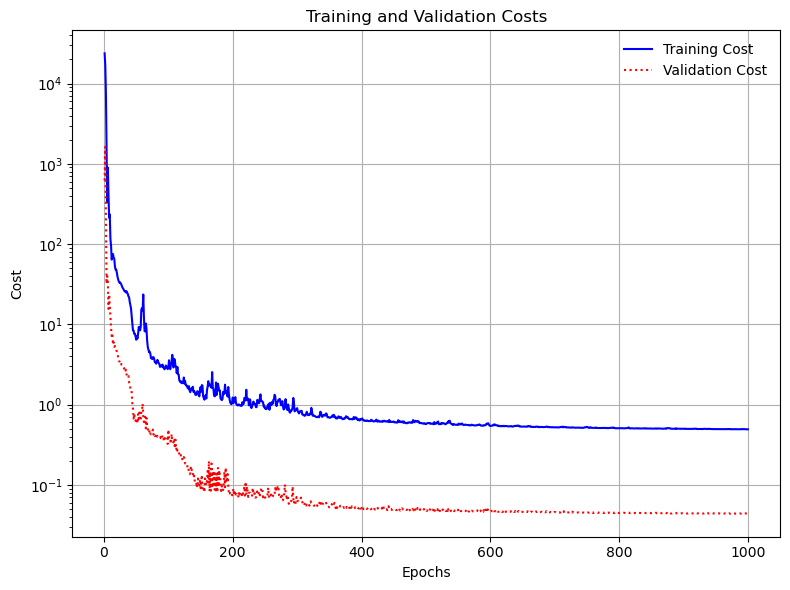

GPU training: elapsed time: 63.38414931297302 seconds


In [6]:
# Create Net model class
# PPmodel = Net_relu_xavier_BN_dropout_decay([1, 20, 20, 20, 2])
# PPmodel = Net_relu_xavier([1, 20, 20, 20, 2])
# PPmodel = Net_relu_xavier_decay1([1, 20, 20, 20, 2], 1.5, 6)
PPmodel = Net_relu_xavier_decay2([1, 20, 20, 20, 2])

PPmodel.eval()
NN_init = PPmodel(val_dataset.q)
plotPP([val_dataset.q, val_dataset.q], [val_dataset.vq_Cd, NN_init[:, 0]], [val_dataset.vq_Se, NN_init[:, 1]], ["ZungerForm", "NN_init"], ["-", ":"], False)

# Initialize the NN parameters to fit the current Zunger form
def init_Zunger_weighted_mse(yhat,y,weight):
    return torch.mean(weight*(yhat-y)**2)
#criterion=nn.MSELoss()

'''
def init_Zunger_train(model, train_loader, val_loader, criterion, optimizer, scheduler, scheduler_step, epochs, plot_every):
    training_cost=[]
    validation_cost=[]
    for epoch in range(epochs):
        train_cost = 0
        val_cost = 0
        for q, vq_Cd, vq_Se, w in train_loader:
            model.train()
            outputs = model(q)
            Cd_pred, Se_pred = torch.split(outputs, 1, dim=1)
            loss = criterion(Cd_pred, vq_Cd, w) + criterion(Se_pred, vq_Se, w)
            train_cost += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        training_cost.append(train_cost)
        if epoch > 0 and epoch % scheduler_step == 0:
            scheduler.step()
        for q, vq_Cd, vq_Se, w in val_loader:
            model.eval()
            outputs = model(q)
            Cd_pred, Se_pred = torch.split(outputs, 1, dim=1)
            loss = criterion(Cd_pred, vq_Cd, w) + criterion(Se_pred, vq_Se, w)
            val_cost += loss.item()
            if (epoch + 1) % plot_every == 0:
                print(f'Epoch [{epoch+1}/{epochs}], Validation Loss: {loss.item():.4f}')
                plotPP([q, q], [vq_Cd, Cd_pred], [vq_Se, Se_pred], ["ZungerForm", f"NN_{epoch+1}"], ["-", ":"], True);

        validation_cost.append(val_cost)
    plot_training_validation_cost(training_cost, validation_cost, True)
    return (training_cost, validation_cost)
'''

def init_Zunger_train_GPU(model, device, train_loader, val_loader, criterion, optimizer, scheduler, scheduler_step, epochs, plot_every):
    training_cost=[]
    validation_cost=[]
    model.to(device)
    for epoch in range(epochs):
        train_cost = 0
        val_cost = 0
        for q, vq_Cd, vq_Se, w in train_loader:
            model.train()
            q = q.to(device) 
            vq_Cd = vq_Cd.to(device)
            vq_Se = vq_Se.to(device)
            w = w.to(device)
            
            outputs = model(q)
            Cd_pred, Se_pred = torch.split(outputs, 1, dim=1)
            loss = criterion(Cd_pred, vq_Cd, w) + criterion(Se_pred, vq_Se, w)
            train_cost += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        training_cost.append(train_cost)
        if epoch > 0 and epoch % scheduler_step == 0:
            scheduler.step()
        for q, vq_Cd, vq_Se, w in val_loader:
            model.eval()
            q = q.to(device) 
            vq_Cd = vq_Cd.to(device)
            vq_Se = vq_Se.to(device)
            w = w.to(device)
            
            outputs = model(q)
            Cd_pred, Se_pred = torch.split(outputs, 1, dim=1)
            loss = criterion(Cd_pred, vq_Cd, w) + criterion(Se_pred, vq_Se, w)
            val_cost += loss.item()
            if (epoch + 1) % plot_every == 0:
                plot_q = q.cpu()
                plot_vq_Cd = vq_Cd.cpu()
                plot_Cd_pred = Cd_pred.cpu()
                plot_vq_Se = vq_Se.cpu()
                plot_Se_pred = Se_pred.cpu()
                print(f'Epoch [{epoch+1}/{epochs}], Validation Loss: {loss.item():.4f}')
                plotPP([plot_q, plot_q], [plot_vq_Cd, plot_Cd_pred], [plot_vq_Se, plot_Se_pred], ["ZungerForm", f"NN_{epoch+1}"], ["-", ":"], True);
        validation_cost.append(val_cost)
    plot_training_validation_cost(training_cost, validation_cost, True)
    return (training_cost, validation_cost)

init_Zunger_criterion = init_Zunger_weighted_mse
init_Zunger_optimizer = torch.optim.Adam(PPmodel.parameters(), lr=0.1)
init_Zunger_scheduler = ExponentialLR(init_Zunger_optimizer, gamma=0.90)
trainloader = DataLoader(dataset = train_dataset, batch_size = int(train_dataset.len/4),shuffle=True)
validationloader = DataLoader(dataset = val_dataset, batch_size =val_dataset.len, shuffle=False)

init_Zunger_num_epochs = 1000
plotEvery = 500

'''
# CPU testing
start_time = time.time()
# device = torch.device("cpu")
init_Zunger_train_GPU(PPmodel, device, trainloader, validationloader, init_Zunger_criterion, init_Zunger_optimizer, init_Zunger_scheduler, 20, init_Zunger_num_epochs, plotEvery)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"CPU training: elapsed time: {elapsed_time} seconds")
'''

start_time = time.time()
init_Zunger_train_GPU(PPmodel, device, trainloader, validationloader, init_Zunger_criterion, init_Zunger_optimizer, init_Zunger_scheduler, 20, init_Zunger_num_epochs, plotEvery)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"GPU training: elapsed time: {elapsed_time} seconds")

os.makedirs('notebook_zbCdSe_results', exist_ok=True)
torch.save(PPmodel.state_dict(), 'notebook_zbCdSe_results/initZunger_PPmodel.pth')

## Timing - neural network initialization training

For `init_Zunger_num_epochs = 1000`, 

|  CPU training  |  GPU training  |
|----------------|----------------|
| 58.5210542678833 seconds | 56.799957275390625 seconds |

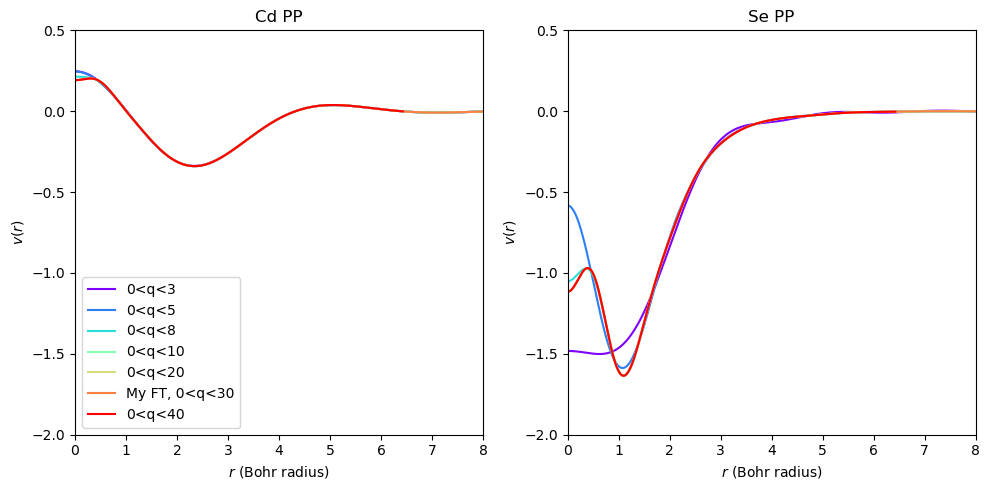

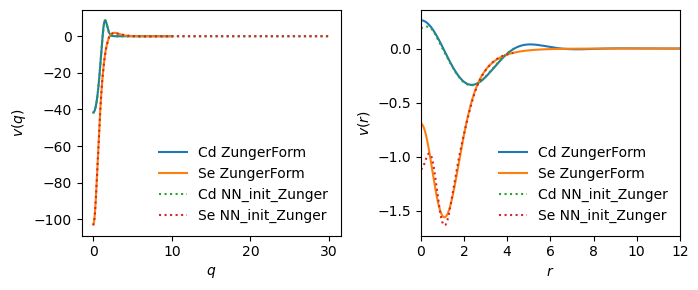

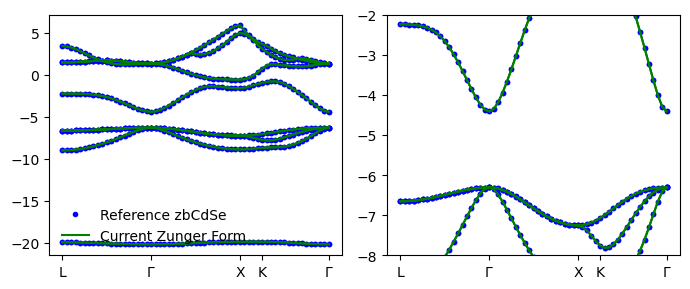

Using this code, can I reproduce the reference band structure to within 1e-11 eV? 


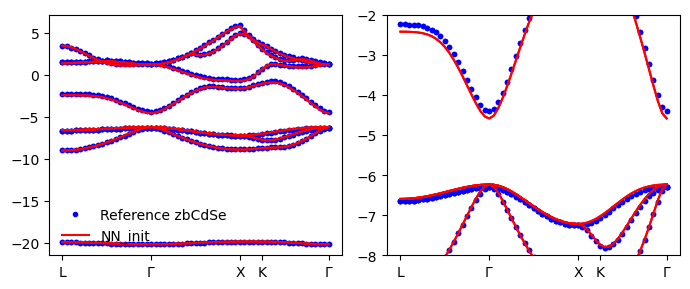

After fitting the NN to the latest function form, we can reproduce a satisfactory band structure. 


In [7]:
PPmodel.eval()
PPmodel.cpu()

qmax = np.array([3.0, 5.0, 8.0, 10.0, 20.0, 30.0, 40.0])
FT_converge_and_write_pp(qmax, PPmodel, 0.0, 8.0, -2.0, 0.5, 30.0, 1024, 
                         'notebook_zbCdSe_results/initZunger_plotPP.png', 'notebook_zbCdSe_results/initZunger_potCd.dat', 
                         'notebook_zbCdSe_results/initZunger_potSe.dat')

basisStates = basis(maxKE, scale, unitCellVectors, gVectors, cellVolume)

# current_Zunger_BandStruct = calcBandStruct(False, PPmodel, basisStates, nkpt, kpt_zbCdSe, nAtoms, atomPos, cellVolume, nBands)
current_Zunger_BandStruct = calcBandStruct_GPU(False, PPmodel, basisStates, nkpt, kpt_zbCdSe, nAtoms, atomPos, cellVolume, nBands, device)
plotBandStruct([Eref_zbCdSe, current_Zunger_BandStruct], ["bo", "g-"], ["Reference zbCdSe", "Current Zunger Form"])
print("Using this code, can I reproduce the reference band structure to within 1e-11 eV? ")
# print(torch.allclose(Eref_zbCdSe, current_Zunger_BandStruct, atol=1e-11))

# NN_init_BandStruct = calcBandStruct(True, PPmodel, basisStates, nkpt, kpt_zbCdSe, nAtoms, atomPos, cellVolume, nBands)
NN_init_BandStruct = calcBandStruct_GPU(True, PPmodel, basisStates, nkpt, kpt_zbCdSe, nAtoms, atomPos, cellVolume, nBands, device)
fig = plotBandStruct([Eref_zbCdSe, NN_init_BandStruct], ["bo", "r-"], ["Reference zbCdSe", "NN_init"])
print("After fitting the NN to the latest function form, we can reproduce a satisfactory band structure. ")
fig.savefig('notebook_zbCdSe_results/initZunger_plotBS.png')

Current Zunger form weighted MSE = 4.670003e-09 
Epoch [1/1], Loss: 9.1097


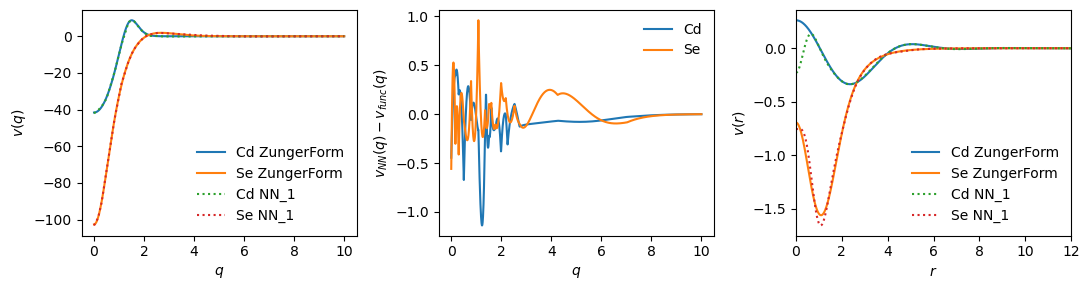

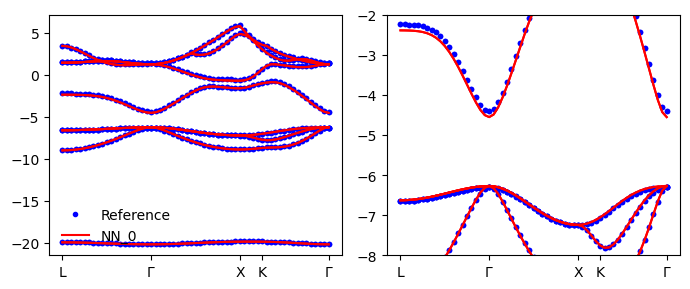

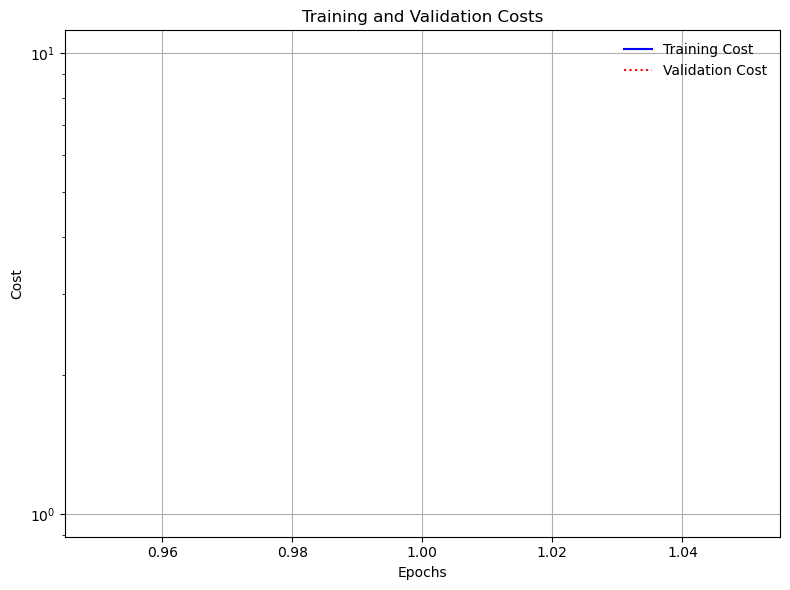

GPU training: elapsed time: 6.342299222946167 seconds


In [8]:
def weighted_mse_bandStruct(Ehat, E, bandWeights, kptWeights):
    if (len(bandWeights)!=nBands) or (len(kptWeights)!=nkpt): 
        raise ValueError("bandWeights or kptWeights lengths aren't correct. ")
        
    newBandWeights = bandWeights.view(1, -1).expand(nkpt, -1)
    newKptWeights = kptWeights.view(-1, 1).expand(-1, nBands)
    
    return torch.sum((Ehat-E)**2 * newBandWeights * newKptWeights)

'''
def BandStruct_train(model, criterion, bandWeights, kptWeights, refBandStruct, optimizer, scheduler, scheduler_step, epochs, plot_every):
    LOSS=[]
    for epoch in range(epochs):
        # train
        model.train()
        NN_outputs = calcBandStruct(True, model, basisStates, nkpt, kpt_zbCdSe, nAtoms, atomPos, cellVolume, nBands)
        loss = criterion(NN_outputs, refBandStruct, bandWeights, kptWeights)
        LOSS.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if epoch > 0 and epoch % scheduler_step == 0:
            scheduler.step()
            
        # evaluation
        if (epoch + 1) % plot_every == 0:
            model.eval()
            NN_outputs = calcBandStruct(True, model, basisStates, nkpt, kpt_zbCdSe, nAtoms, atomPos, cellVolume, nBands)
        
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')
            fig = plotPP([val_dataset.q, val_dataset.q], [val_dataset.vq_Cd, model(val_dataset.q.view(-1, 1))[:, 0]], [val_dataset.vq_Se, model(val_dataset.q.view(-1, 1))[:, 1]], ["ZungerForm", f"NN_{epoch+1}"], ["-", ":"], True);
            fig.savefig('notebook_zbCdSe_results/epoch_%d_plotPP.png' % epoch)
            fig = plotBandStruct([refBandStruct, NN_outputs], ["bo", "r-"], ["Reference", "NN_"+str(epoch)]);
            fig.savefig('notebook_zbCdSe_results/epoch_%d_plotBS.png' % epoch)
            torch.save(PPmodel.state_dict(), 'notebook_zbCdSe_results/epoch_%d_PPmodel.pth' % epoch)
    plot_training_validation_cost(LOSS, LOSS, True)
    return LOSS
'''

################## GPU ##################

def BandStruct_train_GPU(model, device, criterion, bandWeights, kptWeights, refBandStruct, optimizer, scheduler, scheduler_step, max_epochs, plot_every, patience_epochs):
    LOSS=[]
    model.to(device)
    
    best_validation_loss = float('inf')
    no_improvement_count = 0
    
    for epoch in range(max_epochs):
        # train
        model.train()
        NN_outputs = calcBandStruct_GPU(True, model, basisStates, nkpt, kpt_zbCdSe, nAtoms, atomPos, cellVolume, nBands, device)  # move to GPU
        loss = criterion(NN_outputs, refBandStruct, bandWeights, kptWeights)
        LOSS.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if epoch > 0 and epoch % scheduler_step == 0:
            scheduler.step()
            
        # evaluation
        if (epoch + 1) % plot_every == 0:
            model.eval()
            NN_outputs = calcBandStruct_GPU(True, model, basisStates, nkpt, kpt_zbCdSe, nAtoms, atomPos, cellVolume, nBands, device)     # move to GPU
        
            print(f'Epoch [{epoch+1}/{max_epochs}], Loss: {loss.item():.4f}')
            model.cpu()
            fig = plotPP([val_dataset.q, val_dataset.q], [val_dataset.vq_Cd, model(val_dataset.q.view(-1, 1))[:, 0]], [val_dataset.vq_Se, model(val_dataset.q.view(-1, 1))[:, 1]], ["ZungerForm", f"NN_{epoch+1}"], ["-", ":"], True);
            fig.savefig('notebook_zbCdSe_results/epoch_%d_plotPP.png' % epoch)
            model.to(device)
            NN_outputs = NN_outputs.cpu()
            fig = plotBandStruct([refBandStruct, NN_outputs], ["bo", "r-"], ["Reference", "NN_"+str(epoch)]);
            fig.savefig('notebook_zbCdSe_results/epoch_%d_plotBS.png' % epoch)
            torch.save(PPmodel.state_dict(), 'notebook_zbCdSe_results/epoch_%d_PPmodel.pth' % epoch)
        
        # Dynamic stopping: Stop training if no improvement (or less than 1e-4 in the loss) for 'patience' epochs
        if loss.item() < best_validation_loss - 1e-4:
            best_validation_loss = loss.item()
            no_improvement_count = 0
        else:
            no_improvement_count += 1
            
        if no_improvement_count >= patience:
            print("Early stopping at Epoch %d due to lack of improvement." % epoch)
            break
    plot_training_validation_cost(LOSS, LOSS, True)
    return LOSS


PPmodel = Net_relu_xavier_decay2([1, 20, 20, 20, 2])
PPmodel.load_state_dict(torch.load('notebook_zbCdSe_results/initZunger_PPmodel.pth'))

optimizer = torch.optim.Adam(PPmodel.parameters(), lr=0.001)
scheduler = ExponentialLR(optimizer, gamma=0.90)

criterion = weighted_mse_bandStruct
bandWeights=torch.ones(nBands)
bandWeights[4:8] = 2.0
kptWeights=torch.ones(nkpt)
kptWeights[[0, 20, 40]] = 2.0

print("Current Zunger form weighted MSE = %e " % weighted_mse_bandStruct(current_Zunger_BandStruct, Eref_zbCdSe, bandWeights, kptWeights))

max_num_epochs = 1
plotEvery = 1
schedulerStep = 2
patience = max_num_epochs

'''
# CPU testing
# device = torch.device("cpu")
start_time = time.time()
LOSS = BandStruct_train_GPU(PPmodel, device, criterion, bandWeights, kptWeights, Eref_zbCdSe, optimizer, scheduler, schedulerStep, max_num_epochs, plotEvery, patience)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"CPU training: elapsed time: {elapsed_time} seconds")
'''

start_time = time.time()
LOSS = BandStruct_train_GPU(PPmodel, device, criterion, bandWeights, kptWeights, Eref_zbCdSe, optimizer, scheduler, schedulerStep, max_num_epochs, plotEvery, patience)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"GPU training: elapsed time: {elapsed_time} seconds")

For num_epochs = 1, 

CPU training: elapsed time: 16.10703682899475 seconds

GPU training: elapsed time: 5.365472793579102 seconds

There is significant speedup! 

Early stopping at Epoch 26 due to lack of improvement.


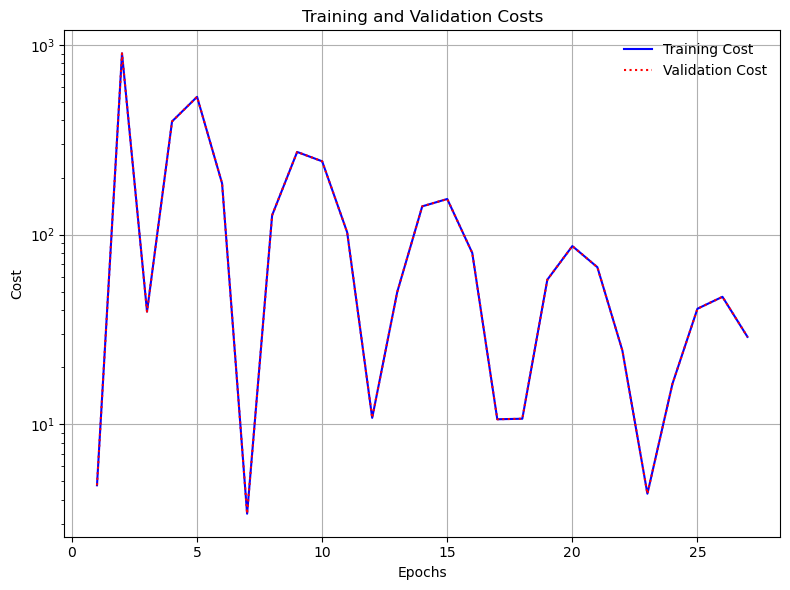

GPU training: elapsed time: 67.3795816898346 seconds


In [9]:
optimizer = torch.optim.Adam(PPmodel.parameters(), lr=0.005)
scheduler = ExponentialLR(optimizer, gamma=0.90)

max_num_epochs = 200
plotEvery = 50
schedulerStep = 20
patience = 20

start_time = time.time()
LOSS = BandStruct_train_GPU(PPmodel, device, criterion, bandWeights, kptWeights, Eref_zbCdSe, optimizer, scheduler, schedulerStep, max_num_epochs, plotEvery, patience)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"GPU training: elapsed time: {elapsed_time} seconds")

## Timing - neural network training on band structure

For `num_epochs = 200`, 

|  CPU training  |  GPU training  |
|----------------|----------------|
| 1985.3864994049072 seconds | 464.7290463447571 seconds |

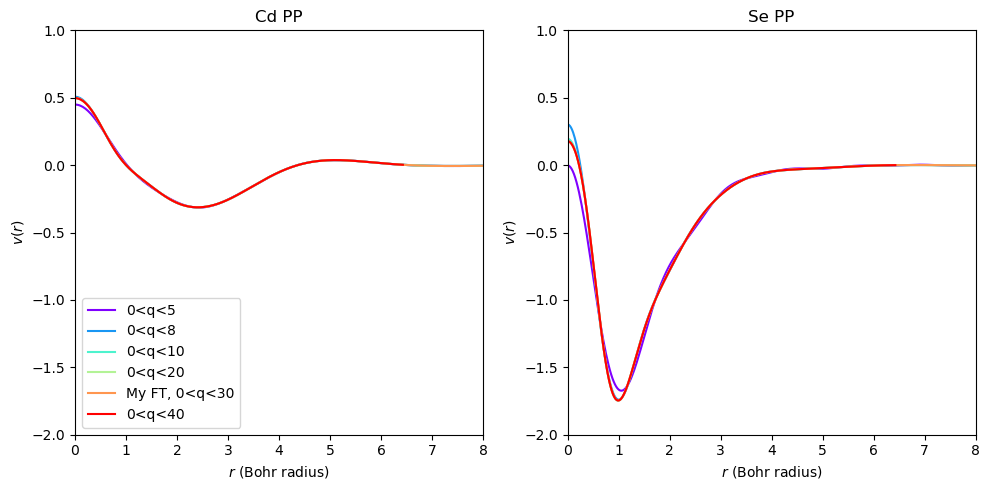

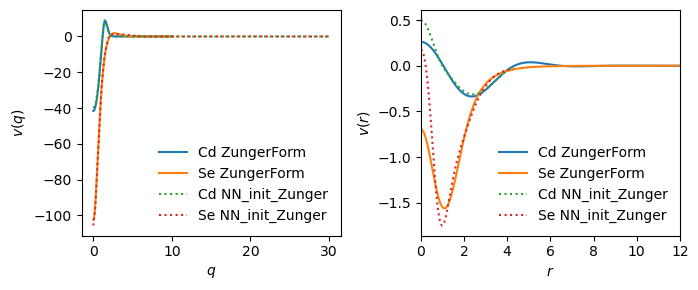

In [10]:
# Write the PP! 

PPmodel = Net_relu_xavier_decay2([1, 20, 20, 20, 2])
PPmodel.load_state_dict(torch.load('notebook_zbCdSe_results/epoch_199_PPmodel.pth')) # , map_location=torch.device('cpu')))

PPmodel.eval()
PPmodel.cpu()

qmax = np.array([5.0, 8.0, 10.0, 20.0, 30.0, 40.0])
FT_converge_and_write_pp(qmax, PPmodel, 0.0, 8.0, -2.0, 1.0, 30.0, 1024, 
                         'notebook_zbCdSe_results/final_plotPP.png', 'notebook_zbCdSe_results/final_potCd.dat', 
                         'notebook_zbCdSe_results/final_potSe.dat')